In [1]:
!pip install scikit-spatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d

In [2]:
!pip install mplstereonet
import mplstereonet

In [3]:
!pip install kneed

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
try:
    import obspy
except:
    !pip install obspy
from obspy.imaging.beachball import beach
from copy import copy
import csv
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
from scipy.optimize import least_squares
from sklearn.linear_model import RANSACRegressor

In [6]:
import pandas as pd

In [7]:
data = np.genfromtxt('5000Events_Spatial_Time.csv', dtype = float, delimiter=',')
focal_50 = np.genfromtxt('50Focal_Mechanisms.csv', dtype = float, delimiter=',')

In [8]:
print(data.shape)
print(focal_50.shape)

(5512, 4)
(50, 7)


# Focal Mechanisms Beachballs

In [9]:
d = {}
# for i in range(50, len(data_list)):
for i in range(0,50):
    s = [int(focal_50[i][4]), int(focal_50[i][5]), int(focal_50[i][6])]
    d['beach'+str(i)] = beach(s, linewidth=0.25, facecolor='r',xy=(float(focal_50[i][1]), float(focal_50[i][0])), width=200)

Text(0.5, 1.0, '50 Focal Mechanisms from SLB')

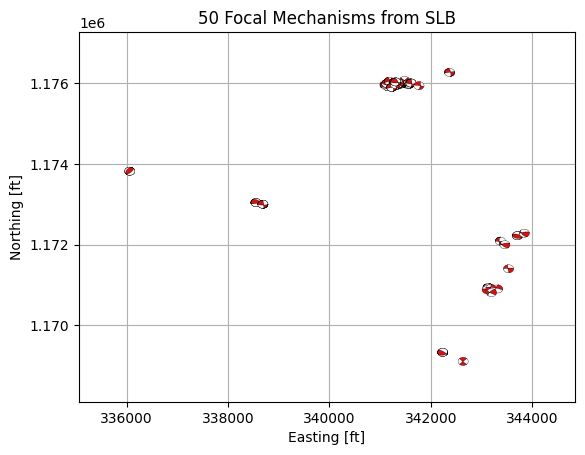

In [10]:
ax = plt.gca()
for i in range(0,50):
  d_new = copy(d['beach'+str(i)])
  ax.add_collection(d_new)
# ax.set_aspect("equal")
ax.set_xlim((np.min(focal_50[:,1])-1000, np.max(focal_50[:,1])+1000))
ax.set_ylim((np.min(focal_50[:,0])-1000, np.max(focal_50[:,0])+1000))
plt.grid()
plt.xlabel('Easting [ft]')
plt.ylabel('Northing [ft]')
plt.title("50 Focal Mechanisms from SLB")

# First Stage Clustering: Spatial Only

In [11]:
data_df = pd.read_csv('5000Events_Spatial_Time.csv')

In [12]:
data_df.head()

SLB Northing (ft)  SLB Easting (ft)  SLB Elevation (ft)   SLB Origin Time
0            1168900            340919               -6309   12/15/2011 0:57
1            1170456            340977               -6259  12/17/2011 16:10
2            1170579            341134               -6362    1/9/2012 18:41
3            1170487            341118               -6379   1/10/2012 17:01
4            1166597            341528               -6053   1/13/2012 23:28

Encode Time in suitable format

In [13]:
# Convert datetime column to datetime object
data_df['SLB Origin Time'] = pd.to_datetime(data_df['SLB Origin Time'], format = '%m/%d/%Y %H:%M' )

In [14]:
data_df.head()

SLB Northing (ft)  SLB Easting (ft)  SLB Elevation (ft)     SLB Origin Time
0            1168900            340919               -6309 2011-12-15 00:57:00
1            1170456            340977               -6259 2011-12-17 16:10:00
2            1170579            341134               -6362 2012-01-09 18:41:00
3            1170487            341118               -6379 2012-01-10 17:01:00
4            1166597            341528               -6053 2012-01-13 23:28:00

In [15]:
# Calculate the reference date (minimum datetime value)
reference_date = data_df['SLB Origin Time'].min()
print('Starting Time: ' + str(reference_date))

# Convert datetime to timestamp (seconds since the reference date)
data_df['timestamp'] = (data_df['SLB Origin Time'] - reference_date) // pd.Timedelta('1s')

Starting Time: 2011-12-15 00:57:00


In [16]:
data_df.head()

SLB Northing (ft)  SLB Easting (ft)  SLB Elevation (ft)  \
0            1168900            340919               -6309   
1            1170456            340977               -6259   
2            1170579            341134               -6362   
3            1170487            341118               -6379   
4            1166597            341528               -6053   

      SLB Origin Time  timestamp  
0 2011-12-15 00:57:00          0  
1 2011-12-17 16:10:00     227580  
2 2012-01-09 18:41:00    2223840  
3 2012-01-10 17:01:00    2304240  
4 2012-01-13 23:28:00    2586660

In [17]:
data_df = data_df.drop('SLB Origin Time', axis =1)
data_df.head()

SLB Northing (ft)  SLB Easting (ft)  SLB Elevation (ft)  timestamp
0            1168900            340919               -6309          0
1            1170456            340977               -6259     227580
2            1170579            341134               -6362    2223840
3            1170487            341118               -6379    2304240
4            1166597            341528               -6053    2586660

In [18]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
X_train = scaler.fit_transform(data_df[['SLB Northing (ft)', 'SLB Easting (ft)', 'SLB Elevation (ft)']])

In [7]:
inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i , random_state= 0)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
# plt.savefig('Elbow.png', bbox_inches='tight')
plt.show()

In [ ]:
kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
kl.elbow

3

In [8]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(X_train)

scaled_centers = kmeans.cluster_centers_

centers = scaler.inverse_transform(scaled_centers)

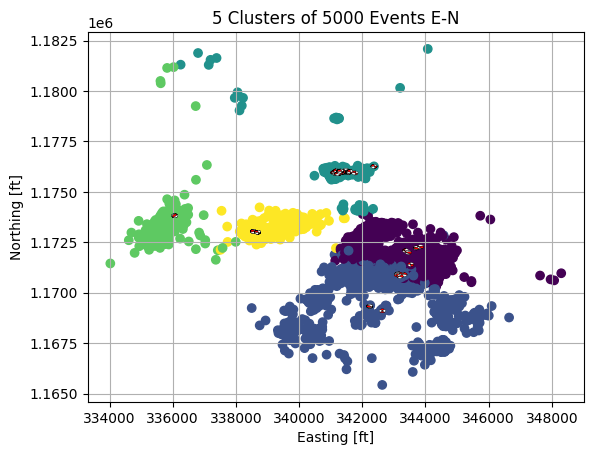

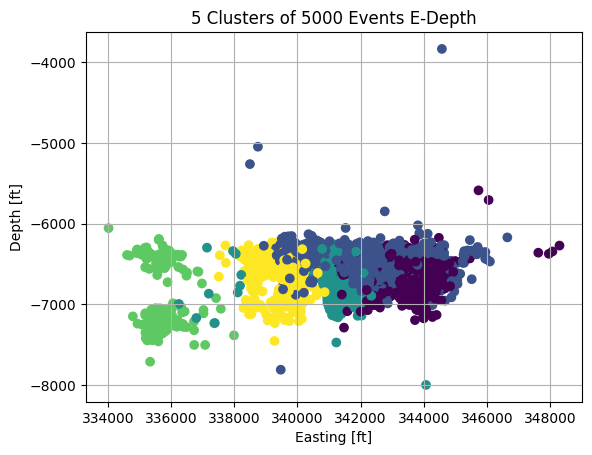

In [20]:
plt.scatter(data_df['SLB Easting (ft)'], data_df['SLB Northing (ft)'], c=kmeans.labels_)
plt.grid()
plt.xlabel("Easting [ft]")
plt.ylabel("Northing [ft]")
plt.title('5 Clusters of 5000 Events E-N')

ax = plt.gca()
for i in range(0,50):
  d_new = copy(d['beach'+str(i)])
  ax.add_collection(d_new)
# ax.set_aspect("equal")

plt.show()

plt.scatter(data_df['SLB Easting (ft)'], data_df['SLB Elevation (ft)'], c=kmeans.labels_)
plt.grid()
plt.xlabel("Easting [ft]")
plt.ylabel("Depth [ft]")
plt.title('5 Clusters of 5000 Events E-Depth')
# ax = plt.gca()
# for i in range(0,50):
#   d_new = copy(d['beach'+str(i)])
#   ax.add_collection(d_new)
# ax.set_aspect("equal")
plt.show()

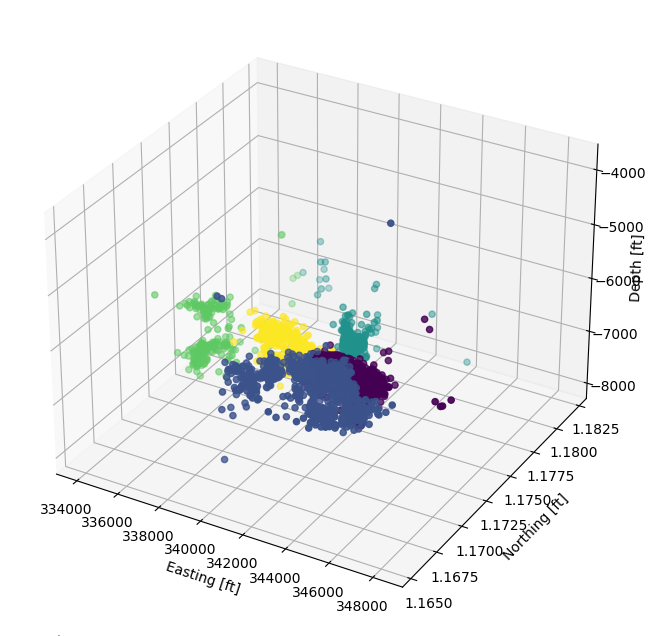

In [21]:
# cmap = matplotlib.cm.get_cmap('Dark2', 4)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_df['SLB Easting (ft)'], data_df['SLB Northing (ft)'], data_df['SLB Elevation (ft)'], c = kmeans.labels_, cmap = 'viridis')
# ax.scatter(centers[:, 0], centers[:, 1], centers[:,2], c='black', s=200, alpha=0.5)
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.7
# plt.savefig('Spatial.png', bbox_inches='tight')
plt.show()

In [22]:
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []

for index in range (len(data[1:])):
    if kmeans.labels_[index] == 0:
        cluster_1.append(data_df.iloc[index].values)
    if kmeans.labels_[index] == 1:
        cluster_2.append(data_df.iloc[index].values)
    if kmeans.labels_[index] == 2:
        cluster_3.append(data_df.iloc[index].values)
    if kmeans.labels_[index] == 3:
        cluster_4.append(data_df.iloc[index].values)
    if kmeans.labels_[index] == 4:
        cluster_5.append(data_df.iloc[index].values)

cluster_1 = np.array(cluster_1)
cluster_2 = np.array(cluster_2)
cluster_3 = np.array(cluster_3)
cluster_4 = np.array(cluster_4)
cluster_5 = np.array(cluster_5)

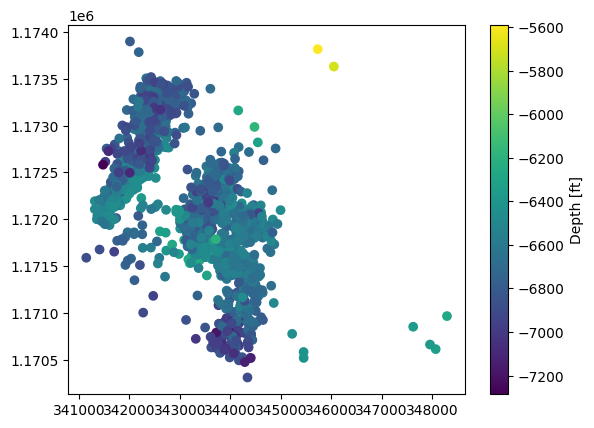

In [23]:
scatter = plt.scatter(cluster_1[:,1], cluster_1[:,0], c=cluster_1[:,2], cmap='viridis')
plt.colorbar(scatter, label='Depth [ft]')

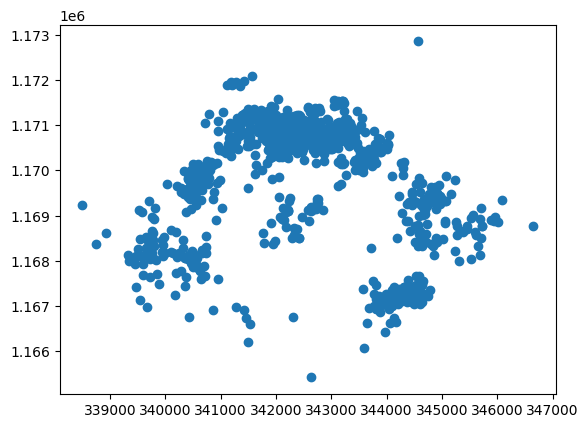

In [24]:
plt.scatter(cluster_2[:,1],cluster_2[:,0])

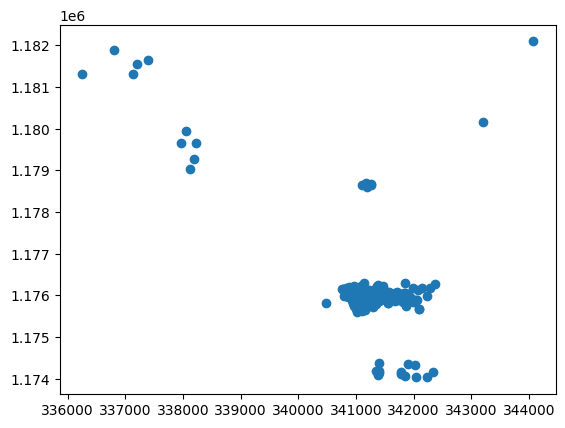

In [25]:
plt.scatter(cluster_3[:,1],cluster_3[:,0])

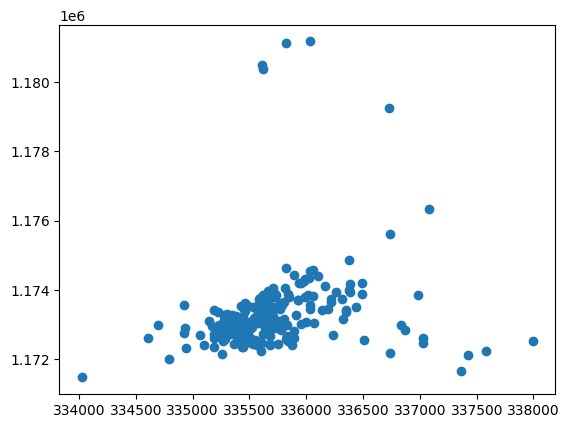

In [26]:
plt.scatter(cluster_4[:,1],cluster_4[:,0])

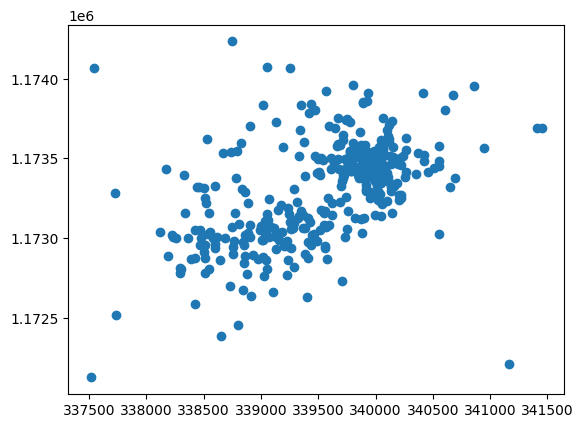

In [27]:
plt.scatter(cluster_5[:,1],cluster_5[:,0])

# Second Stage Clustering: Hierarchial Clustering of Clusters 1 and 2

(3990, 4)


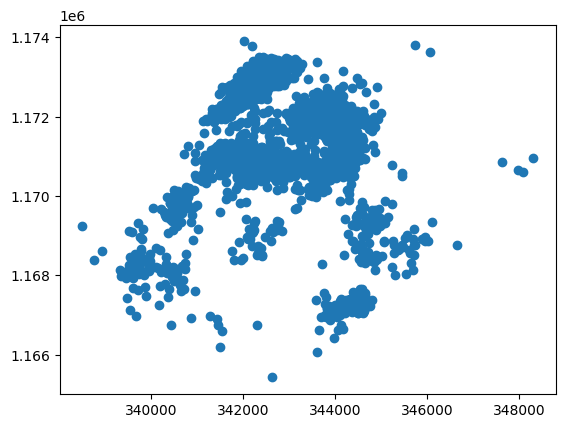

In [28]:
joint_cluster = np.concatenate((cluster_1, cluster_2), axis=0)
print(joint_cluster.shape)
plt.scatter(joint_cluster[:,1], joint_cluster[:,0])

In [6]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
X_train = scaler.fit_transform(joint_cluster[:, 0:3])

inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i , random_state= 0)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
# plt.savefig('Elbow.png', bbox_inches='tight')
plt.show()

In [30]:
kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
kl.elbow

5

In [5]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(X_train)

scaled_centers = kmeans.cluster_centers_

centers = scaler.inverse_transform(scaled_centers)

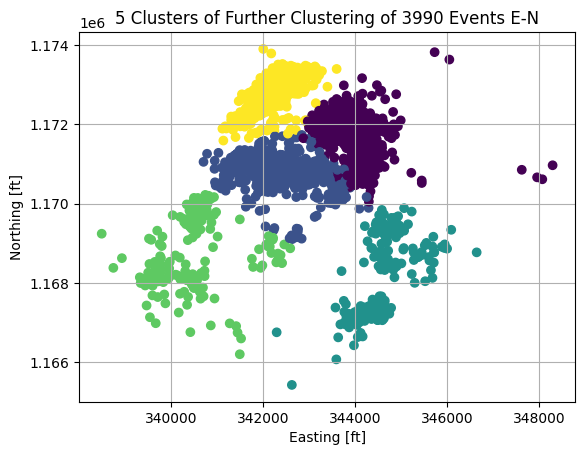

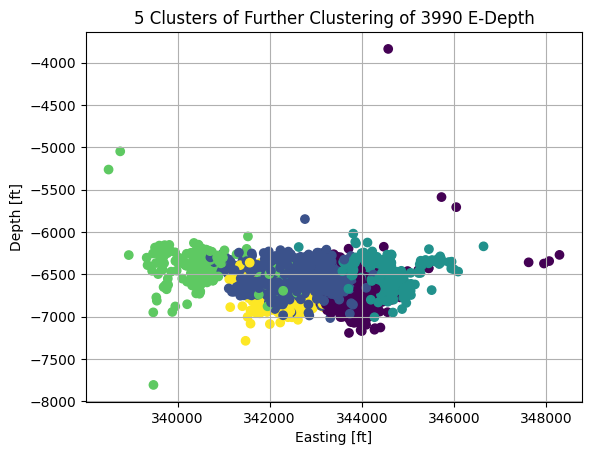

In [32]:
plt.scatter(joint_cluster[:,1], joint_cluster[:,0], c=kmeans.labels_)
plt.grid()
plt.xlabel("Easting [ft]")
plt.ylabel("Northing [ft]")
plt.title('5 Clusters of Further Clustering of 3990 Events E-N')

# ax = plt.gca()
# for i in range(0,50):
#   d_new = copy(d['beach'+str(i)])
#   ax.add_collection(d_new)
# ax.set_aspect("equal")

plt.show()

plt.scatter(joint_cluster[:,1], joint_cluster[:,2], c=kmeans.labels_)
plt.grid()
plt.xlabel("Easting [ft]")
plt.ylabel("Depth [ft]")
plt.title('5 Clusters of Further Clustering of 3990 E-Depth')
# ax = plt.gca()
# for i in range(0,50):
#   d_new = copy(d['beach'+str(i)])
#   ax.add_collection(d_new)
# ax.set_aspect("equal")
plt.show()

In [33]:
cluster_6 = []
cluster_7 = []
cluster_8 = []
cluster_9 = []
cluster_10 = []

for index in range (len(joint_cluster)):
    if kmeans.labels_[index] == 0:
        cluster_6.append(joint_cluster[index])
    if kmeans.labels_[index] == 1:
        cluster_7.append(joint_cluster[index])
    if kmeans.labels_[index] == 2:
        cluster_8.append(joint_cluster[index])
    if kmeans.labels_[index] == 3:
        cluster_9.append(joint_cluster[index])
    if kmeans.labels_[index] == 4:
        cluster_10.append(joint_cluster[index])

cluster_6 = np.array(cluster_6)
cluster_7 = np.array(cluster_7)
cluster_8 = np.array(cluster_8)
cluster_9 = np.array(cluster_9)
cluster_10 = np.array(cluster_10)

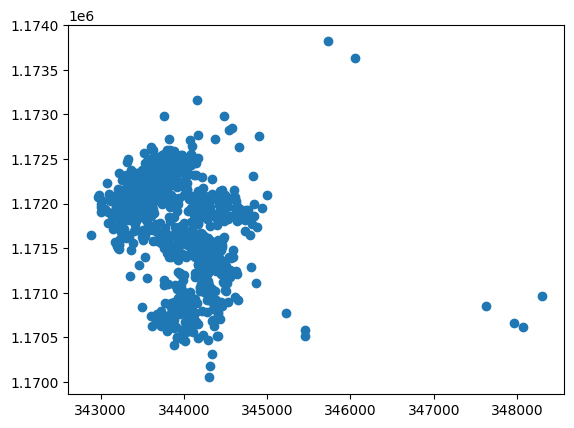

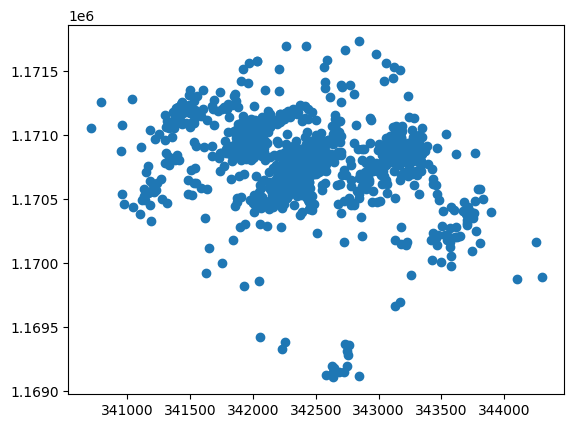

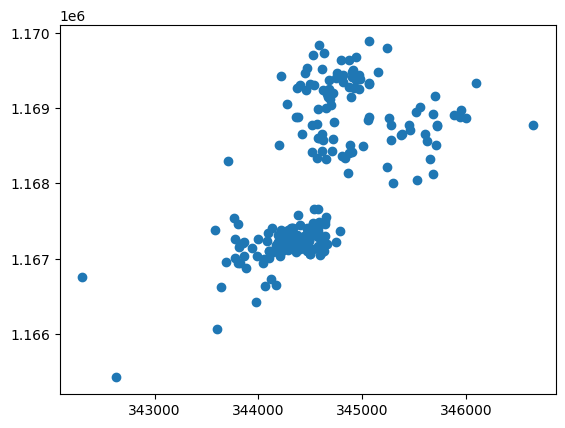

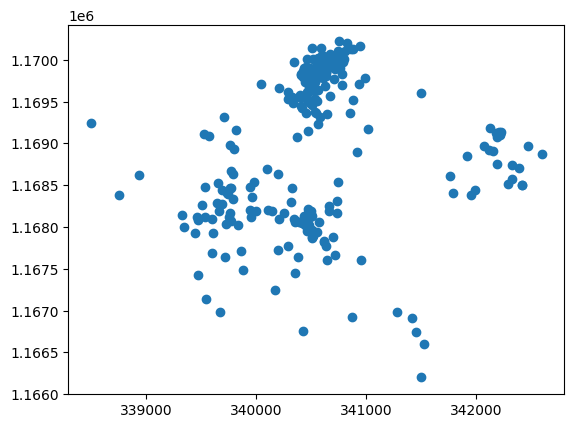

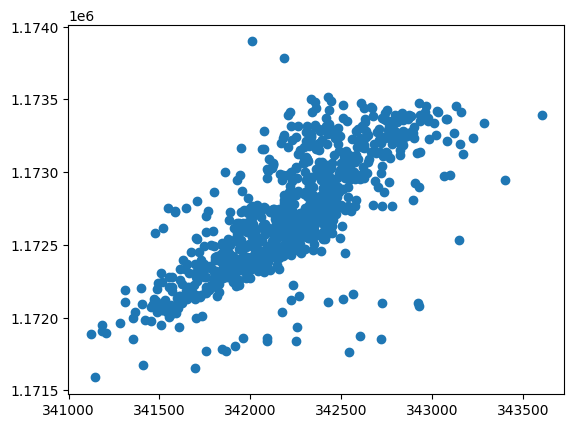

In [34]:
plt.scatter(cluster_6[:,1],cluster_6[:,0])
plt.show()

plt.scatter(cluster_7[:,1],cluster_7[:,0])
plt.show()

plt.scatter(cluster_8[:,1],cluster_8[:,0])
plt.show()

plt.scatter(cluster_9[:,1],cluster_9[:,0])
plt.show()

plt.scatter(cluster_10[:,1],cluster_10[:,0])
plt.show()

# Plotting All Data After Hierarching

Text(0.5, 1.0, '8 Clusters of 5512 Events')

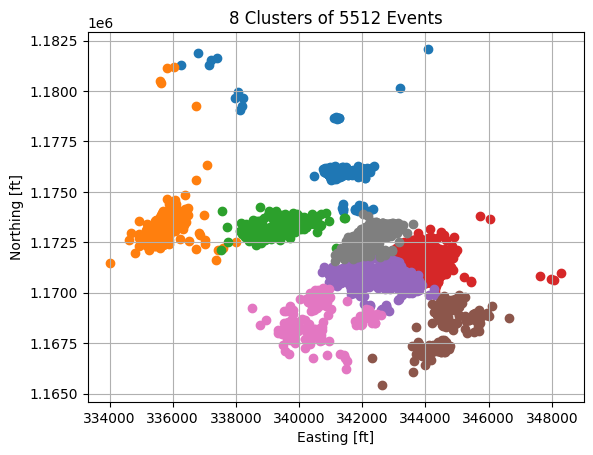

In [35]:
fig, ax = plt.subplots()
ax.scatter(cluster_3[:,1], cluster_3[:,0])
ax.scatter(cluster_4[:,1], cluster_4[:,0])
ax.scatter(cluster_5[:,1], cluster_5[:,0])
ax.scatter(cluster_6[:,1], cluster_6[:,0])
ax.scatter(cluster_7[:,1], cluster_7[:,0])
ax.scatter(cluster_8[:,1], cluster_8[:,0])
ax.scatter(cluster_9[:,1], cluster_9[:,0])
ax.scatter(cluster_10[:,1], cluster_10[:,0])
plt.grid()
plt.xlabel("Easting [ft]")
plt.ylabel("Northing [ft]")
plt.title('8 Clusters of 5512 Events')


# Third Stage Clustering: Temporal Clustering with DBSCAN

### Cluster 3

Use Time Only for density clustering

In [ ]:
# scaler = MinMaxScaler()
# # scaler = StandardScaler()
# # scaler = RobustScaler()
# X_train = scaler.fit_transform(cluster_3[:,-1].reshape(-1,1))

Use Time and Space for density clustering

In [36]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
X_train = scaler.fit_transform(cluster_3)

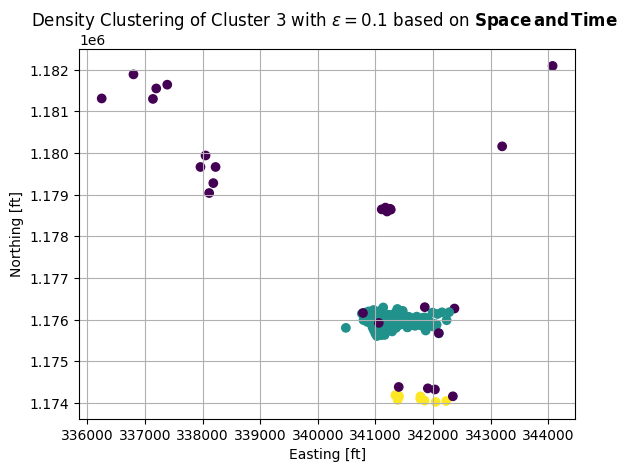

In [37]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_3)

dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_3[:,1], cluster_3[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 3 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

Text(0.5, 1.0, 'Cluster 3 E-Depth')

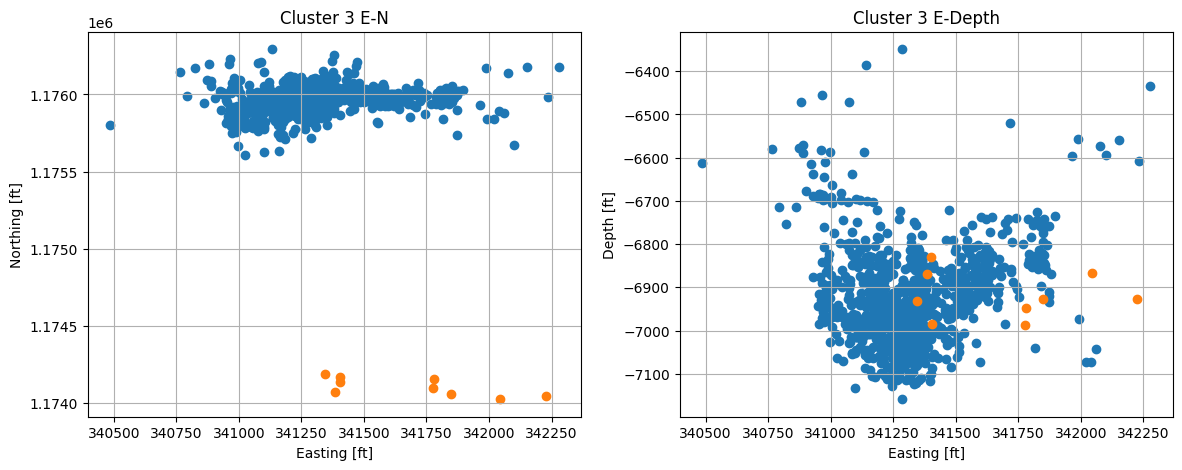

In [38]:
cluster_3a = []
cluster_3b = []


for index in range (len(cluster_3)):
    if dbscan.labels_[index] == 0:
        cluster_3a.append(cluster_3[index])
    if dbscan.labels_[index] == 1:
        cluster_3b.append(cluster_3[index])



cluster_3a = np.array(cluster_3a)
cluster_3b = np.array(cluster_3b)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_3a[:,1], cluster_3a[:,0])
ax.scatter(cluster_3b[:,1], cluster_3b[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 3 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_3a[:,1], cluster_3a[:,2])
ax.scatter(cluster_3b[:,1], cluster_3b[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 3 E-Depth')

In [39]:
np.savetxt("cluster3a.csv", cluster_3a, delimiter=",")
np.savetxt("cluster3b.csv", cluster_3b, delimiter=",")

### Cluster 4

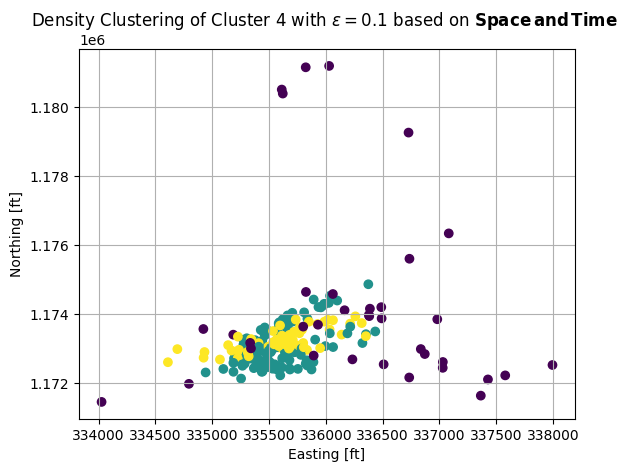

In [40]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_4)

dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_4[:,1], cluster_4[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 4 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

Text(0.5, 1.0, 'Cluster 4 E-Depth')

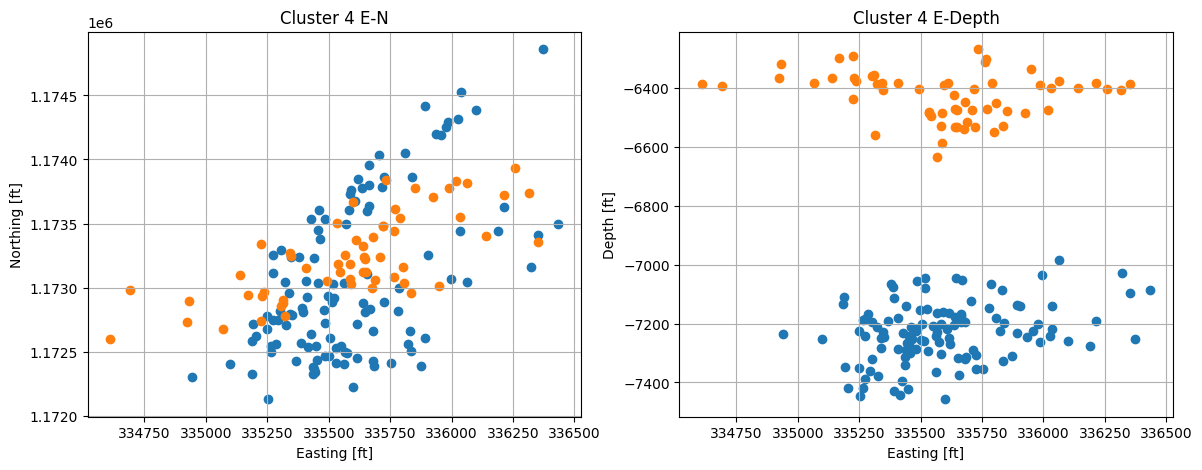

In [41]:
cluster_4a = []
cluster_4b = []


for index in range (len(cluster_4)):
    if dbscan.labels_[index] == 0:
        cluster_4a.append(cluster_4[index])
    if dbscan.labels_[index] == 1:
        cluster_4b.append(cluster_4[index])



cluster_4a = np.array(cluster_4a)
cluster_4b = np.array(cluster_4b)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_4a[:,1], cluster_4a[:,0])
ax.scatter(cluster_4b[:,1], cluster_4b[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 4 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_4a[:,1], cluster_4a[:,2])
ax.scatter(cluster_4b[:,1], cluster_4b[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 4 E-Depth')

In [42]:
np.savetxt("cluster4a.csv", cluster_4a, delimiter=",")
np.savetxt("cluster4b.csv", cluster_4b, delimiter=",")

### Cluster 5

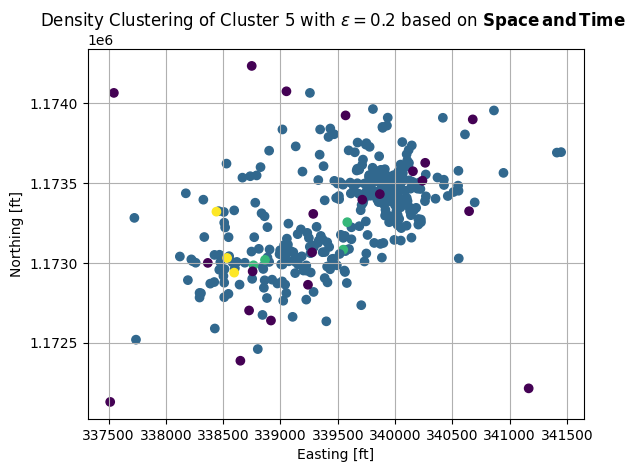

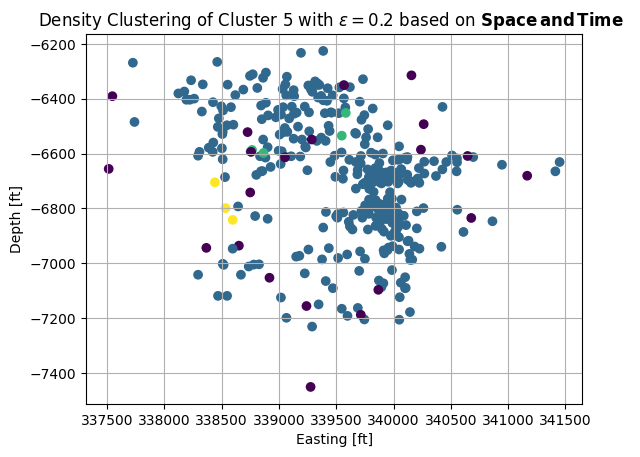

In [43]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_5)

dbscan = DBSCAN(eps=0.2, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_5[:,1], cluster_5[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 5 with $\epsilon=0.2$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_5[:,1], cluster_5[:,2], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Depth [ft]")
ax.set_title('Density Clustering of Cluster 5 with $\epsilon=0.2$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

Text(0.5, 1.0, 'Cluster 5 E-Depth')

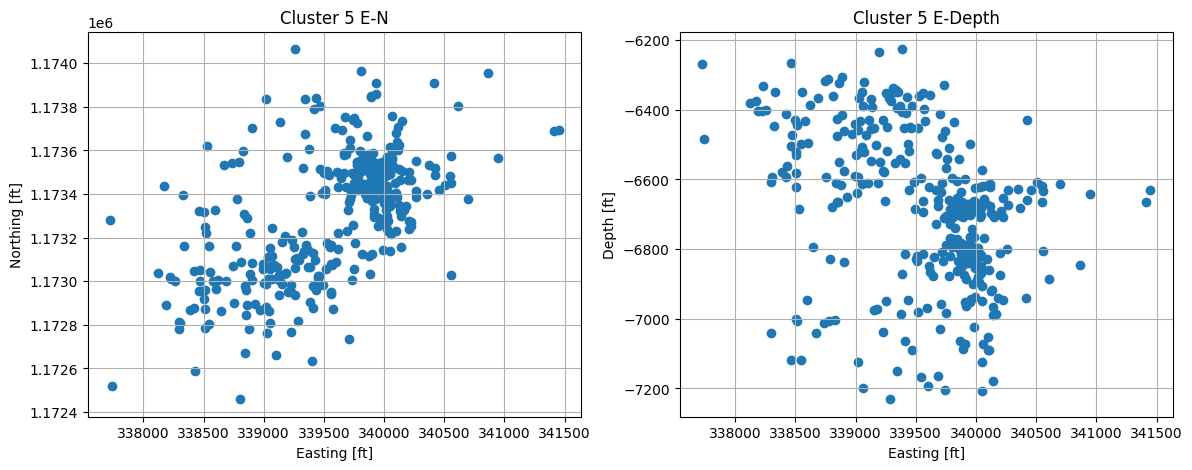

In [44]:
cluster_5a = []


for index in range (len(cluster_5)):
    if dbscan.labels_[index] == 0:
        cluster_5a.append(cluster_5[index])

cluster_5a = np.array(cluster_5a)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_5a[:,1], cluster_5a[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 5 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_5a[:,1], cluster_5a[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 5 E-Depth')

In [45]:
np.savetxt("cluster5a.csv", cluster_5a, delimiter=",")

### Cluster 6

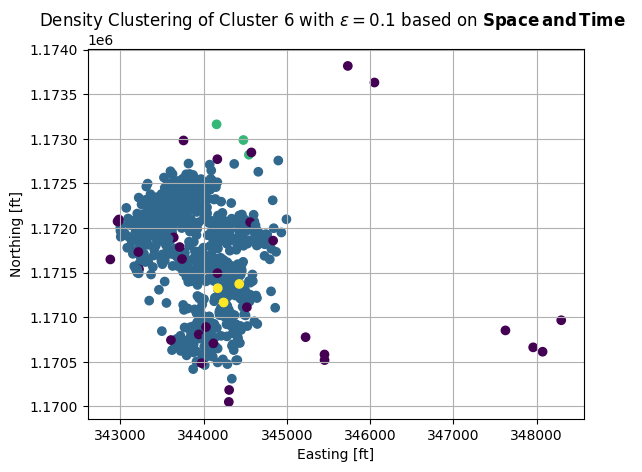

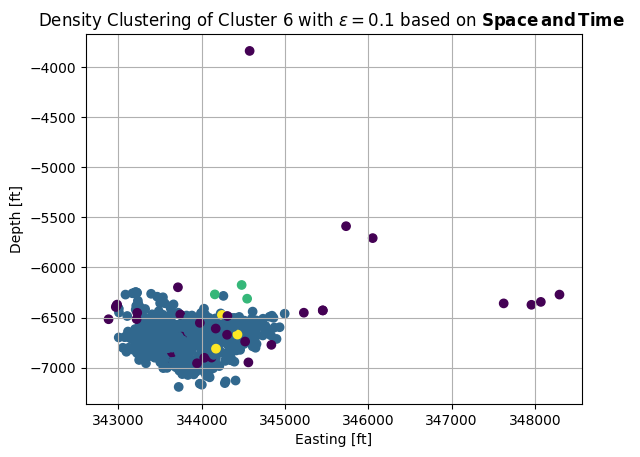

In [46]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_6)

dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_6[:,1], cluster_6[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 6 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_6[:,1], cluster_6[:,2], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Depth [ft]")
ax.set_title('Density Clustering of Cluster 6 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

In [48]:
dbscan.labels_

unique, counts = np.unique(dbscan.labels_, return_counts=True)

dict(zip(unique, counts))

{-1: 32, 0: 899, 1: 3, 2: 3}

Text(0.5, 1.0, 'Cluster 6 E-Depth')

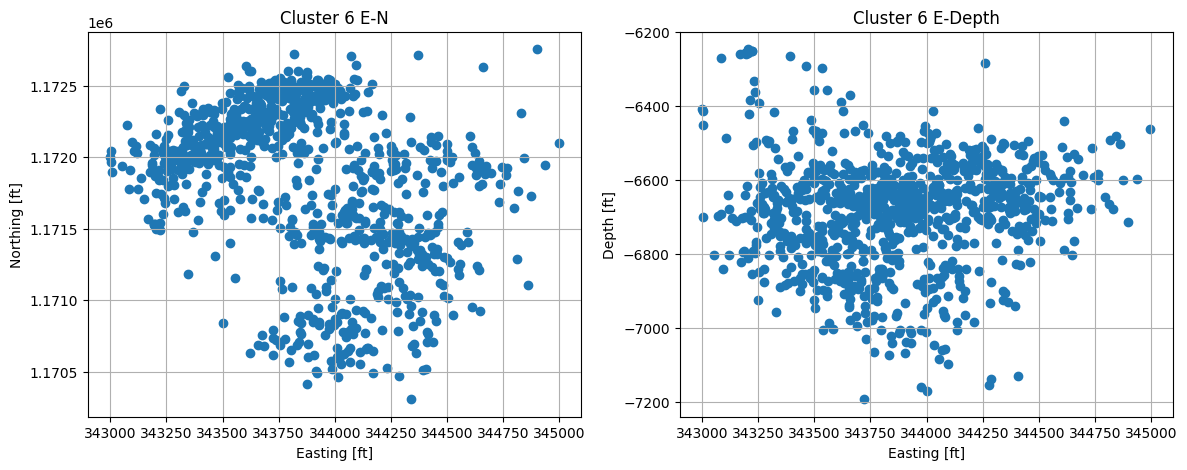

In [47]:
cluster_6a = []

for index in range (len(cluster_6)):
    if dbscan.labels_[index] == 0:
        cluster_6a.append(cluster_6[index])

cluster_6a = np.array(cluster_6a)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_6a[:,1], cluster_6a[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 6 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_6a[:,1], cluster_6a[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 6 E-Depth')

In [49]:
np.savetxt("cluster6a.csv", cluster_6a, delimiter=",")

### Cluster 7

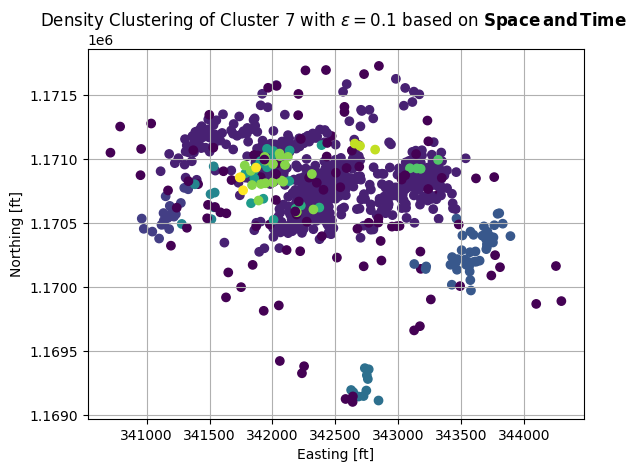

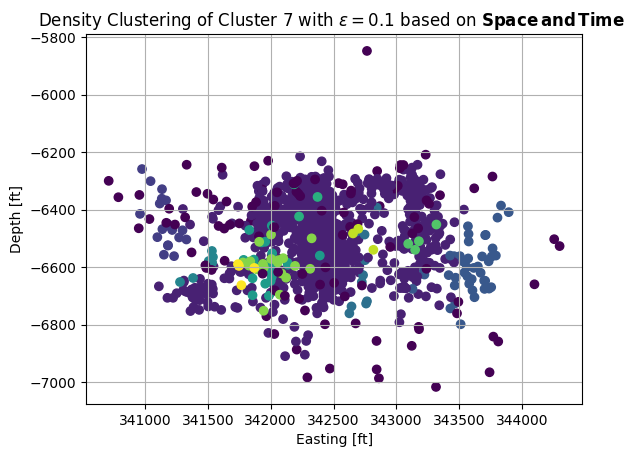

In [50]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_7)

dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_7[:,1], cluster_7[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 7 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_7[:,1], cluster_7[:,2], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Depth [ft]")
ax.set_title('Density Clustering of Cluster 7 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

In [51]:
dbscan.labels_

unique, counts = np.unique(dbscan.labels_, return_counts=True)

dict(zip(unique, counts))

{-1: 108,
 0: 1385,
 1: 19,
 2: 42,
 3: 10,
 4: 7,
 5: 24,
 6: 3,
 7: 4,
 8: 19,
 9: 3,
 10: 4}

Text(0.5, 1.0, 'Cluster 7 E-Depth')

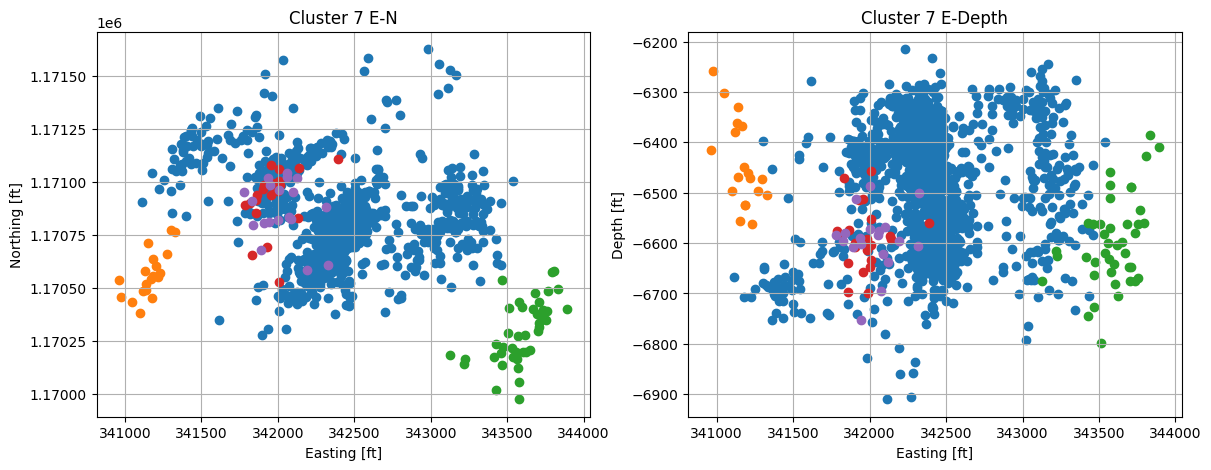

In [52]:
cluster_7a = []
cluster_7b = []
cluster_7c = []
cluster_7d = []
cluster_7e = []

for index in range (len(cluster_7)):
    if dbscan.labels_[index] == 0:
        cluster_7a.append(cluster_7[index])
    if dbscan.labels_[index] == 1:
        cluster_7b.append(cluster_7[index])
    if dbscan.labels_[index] == 2:
        cluster_7c.append(cluster_7[index])
    if dbscan.labels_[index] == 5:
        cluster_7d.append(cluster_7[index])
    if dbscan.labels_[index] == 8:
        cluster_7e.append(cluster_7[index])


cluster_7a = np.array(cluster_7a)
cluster_7b = np.array(cluster_7b)
cluster_7c = np.array(cluster_7c)
cluster_7d = np.array(cluster_7d)
cluster_7e = np.array(cluster_7e)

fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_7a[:,1], cluster_7a[:,0])
ax.scatter(cluster_7b[:,1], cluster_7b[:,0])
ax.scatter(cluster_7c[:,1], cluster_7c[:,0])
ax.scatter(cluster_7d[:,1], cluster_7d[:,0])
ax.scatter(cluster_7e[:,1], cluster_7e[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 7 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_7a[:,1], cluster_7a[:,2])
ax.scatter(cluster_7b[:,1], cluster_7b[:,2])
ax.scatter(cluster_7c[:,1], cluster_7c[:,2])
ax.scatter(cluster_7d[:,1], cluster_7d[:,2])
ax.scatter(cluster_7e[:,1], cluster_7e[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 7 E-Depth')

In [53]:
np.savetxt("cluster7a.csv", cluster_7a, delimiter=",")
np.savetxt("cluster7b.csv", cluster_7b, delimiter=",")
np.savetxt("cluster7c.csv", cluster_7c, delimiter=",")
np.savetxt("cluster7d.csv", cluster_7d, delimiter=",")
np.savetxt("cluster7e.csv", cluster_7e, delimiter=",")

### Cluster 8

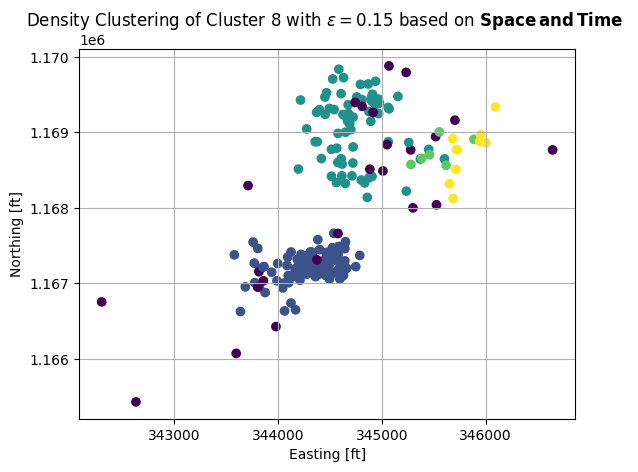

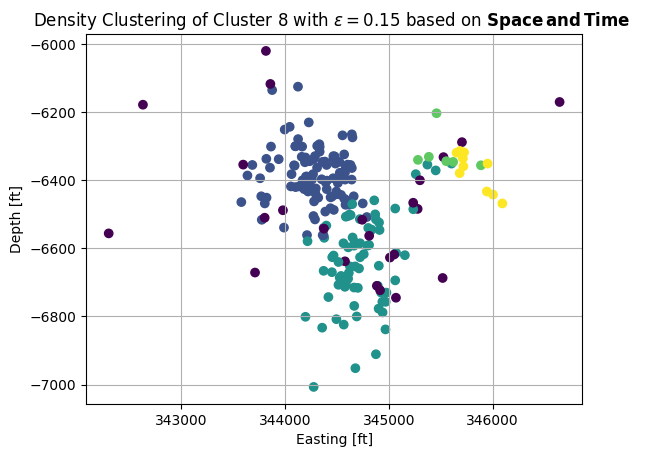

In [54]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_8)

dbscan = DBSCAN(eps=0.15, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_8[:,1], cluster_8[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 8 with $\epsilon=0.15$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_8[:,1], cluster_8[:,2], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Depth [ft]")
ax.set_title('Density Clustering of Cluster 8 with $\epsilon=0.15$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

In [55]:
dbscan.labels_

unique, counts = np.unique(dbscan.labels_, return_counts=True)

dict(zip(unique, counts))

{-1: 24, 0: 104, 1: 71, 2: 6, 3: 10}

Text(0.5, 1.0, 'Cluster 8 E-Depth')

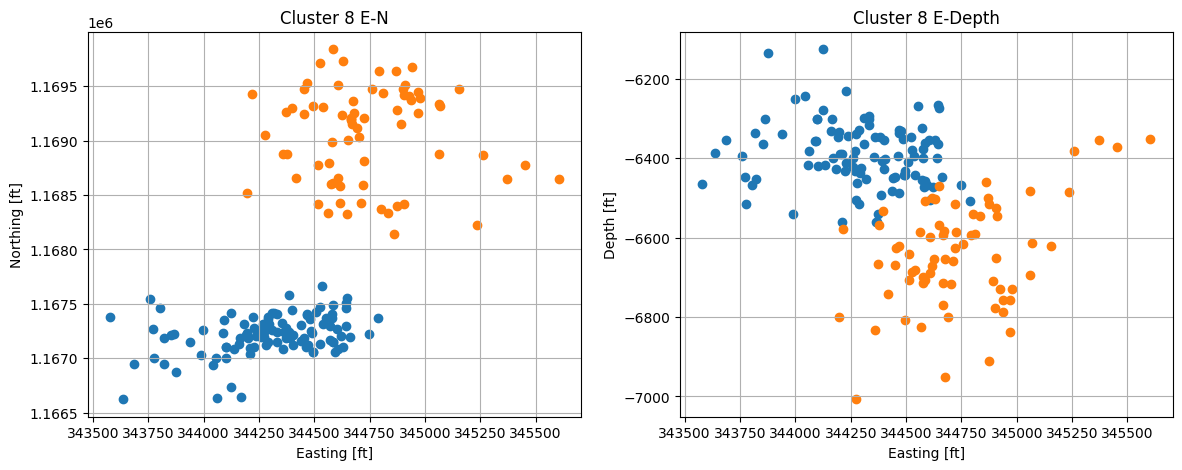

In [56]:
cluster_8a = []
cluster_8b = []

for index in range (len(cluster_8)):
    if dbscan.labels_[index] == 0:
        cluster_8a.append(cluster_8[index])
    if dbscan.labels_[index] == 1:
        cluster_8b.append(cluster_8[index])

cluster_8a = np.array(cluster_8a)
cluster_8b = np.array(cluster_8b)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_8a[:,1], cluster_8a[:,0])
ax.scatter(cluster_8b[:,1], cluster_8b[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 8 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_8a[:,1], cluster_8a[:,2])
ax.scatter(cluster_8b[:,1], cluster_8b[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 8 E-Depth')

In [57]:
np.savetxt("cluster8a.csv", cluster_8a, delimiter=",")
np.savetxt("cluster8b.csv", cluster_8b, delimiter=",")

### Cluster 9

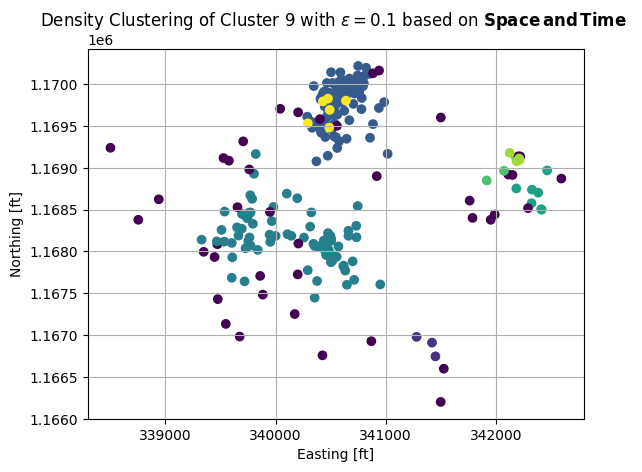

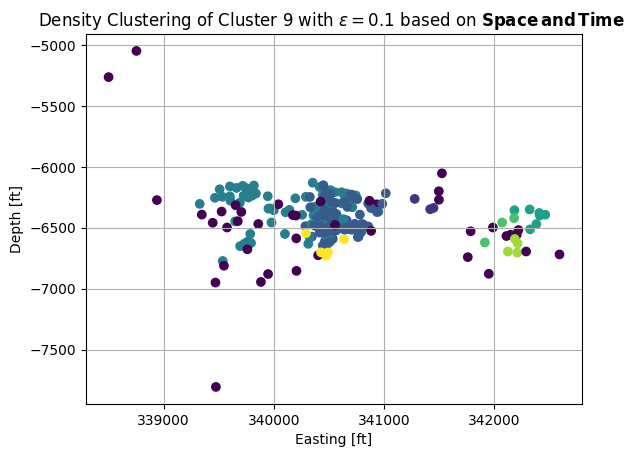

In [58]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_9)

dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_9[:,1], cluster_9[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 9 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_9[:,1], cluster_9[:,2], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Depth [ft]")
ax.set_title('Density Clustering of Cluster 9 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

In [59]:
dbscan.labels_

unique, counts = np.unique(dbscan.labels_, return_counts=True)

dict(zip(unique, counts))

{-1: 42, 0: 3, 1: 116, 2: 79, 3: 7, 4: 3, 5: 4, 6: 6}

Text(0.5, 1.0, 'Cluster 9 E-Depth')

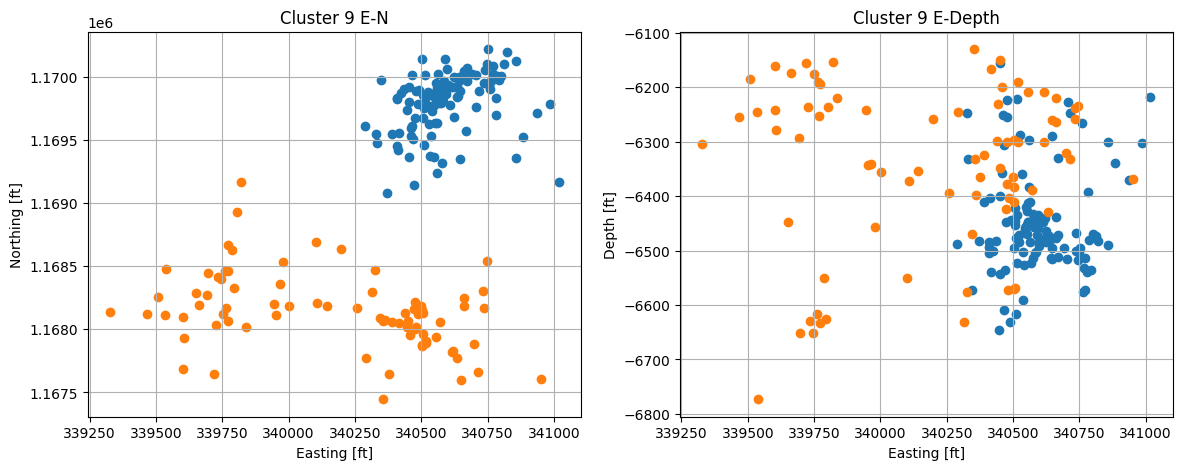

In [60]:
cluster_9a = []
cluster_9b = []

for index in range (len(cluster_9)):
    if dbscan.labels_[index] == 1:
        cluster_9a.append(cluster_9[index])
    if dbscan.labels_[index] == 2:
        cluster_9b.append(cluster_9[index])

cluster_9a = np.array(cluster_9a)
cluster_9b = np.array(cluster_9b)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_9a[:,1], cluster_9a[:,0])
ax.scatter(cluster_9b[:,1], cluster_9b[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 9 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_9a[:,1], cluster_9a[:,2])
ax.scatter(cluster_9b[:,1], cluster_9b[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 9 E-Depth')

In [61]:
np.savetxt("cluster9a.csv", cluster_9a, delimiter=",")
np.savetxt("cluster9b.csv", cluster_9b, delimiter=",")

### Cluster 10

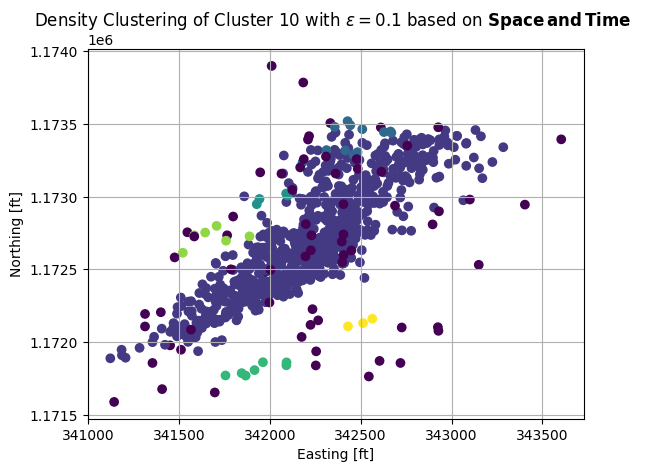

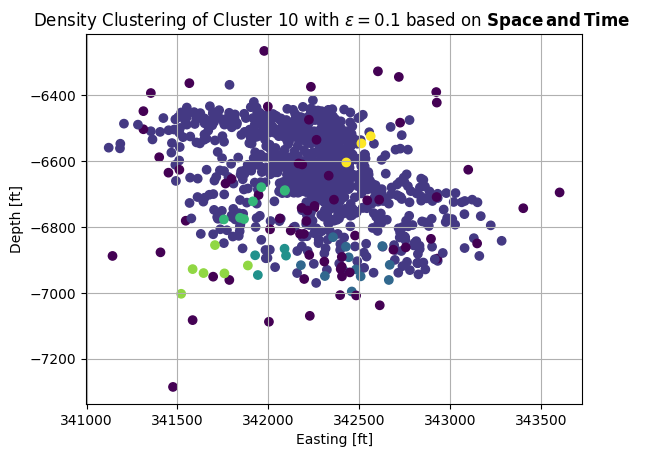

In [62]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(cluster_10)

dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(X_train)

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_10[:,1], cluster_10[:,0], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
ax.set_title('Density Clustering of Cluster 10 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(cluster_10[:,1], cluster_10[:,2], c=dbscan.labels_)
ax.grid()
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Depth [ft]")
ax.set_title('Density Clustering of Cluster 10 with $\epsilon=0.1$ based on $\mathbf{Space \, and \, Time}$  ')
plt.show()

In [63]:
dbscan.labels_

unique, counts = np.unique(dbscan.labels_, return_counts=True)

dict(zip(unique, counts))

{-1: 66, 0: 852, 1: 12, 2: 4, 3: 7, 4: 6, 5: 3}

Text(0.5, 1.0, 'Cluster 10 E-Depth')

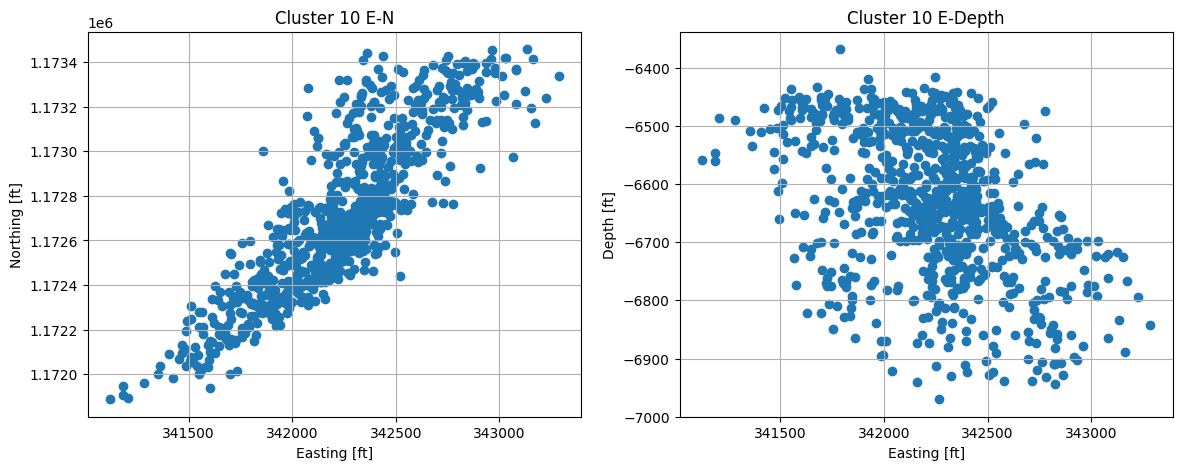

In [64]:
cluster_10a = []

for index in range (len(cluster_10)):
    if dbscan.labels_[index] == 0:
        cluster_10a.append(cluster_10[index])

cluster_10a = np.array(cluster_10a)


fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_10a[:,1], cluster_10a[:,0])
ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 10 E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_10a[:,1], cluster_10a[:,2])
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()
plt.title('Cluster 10 E-Depth')

In [65]:
np.savetxt("cluster10a.csv", cluster_10a, delimiter=",")

PLOT ALL CLUSTERS

Text(0.5, 1.0, 'All Clusters E-Depth')

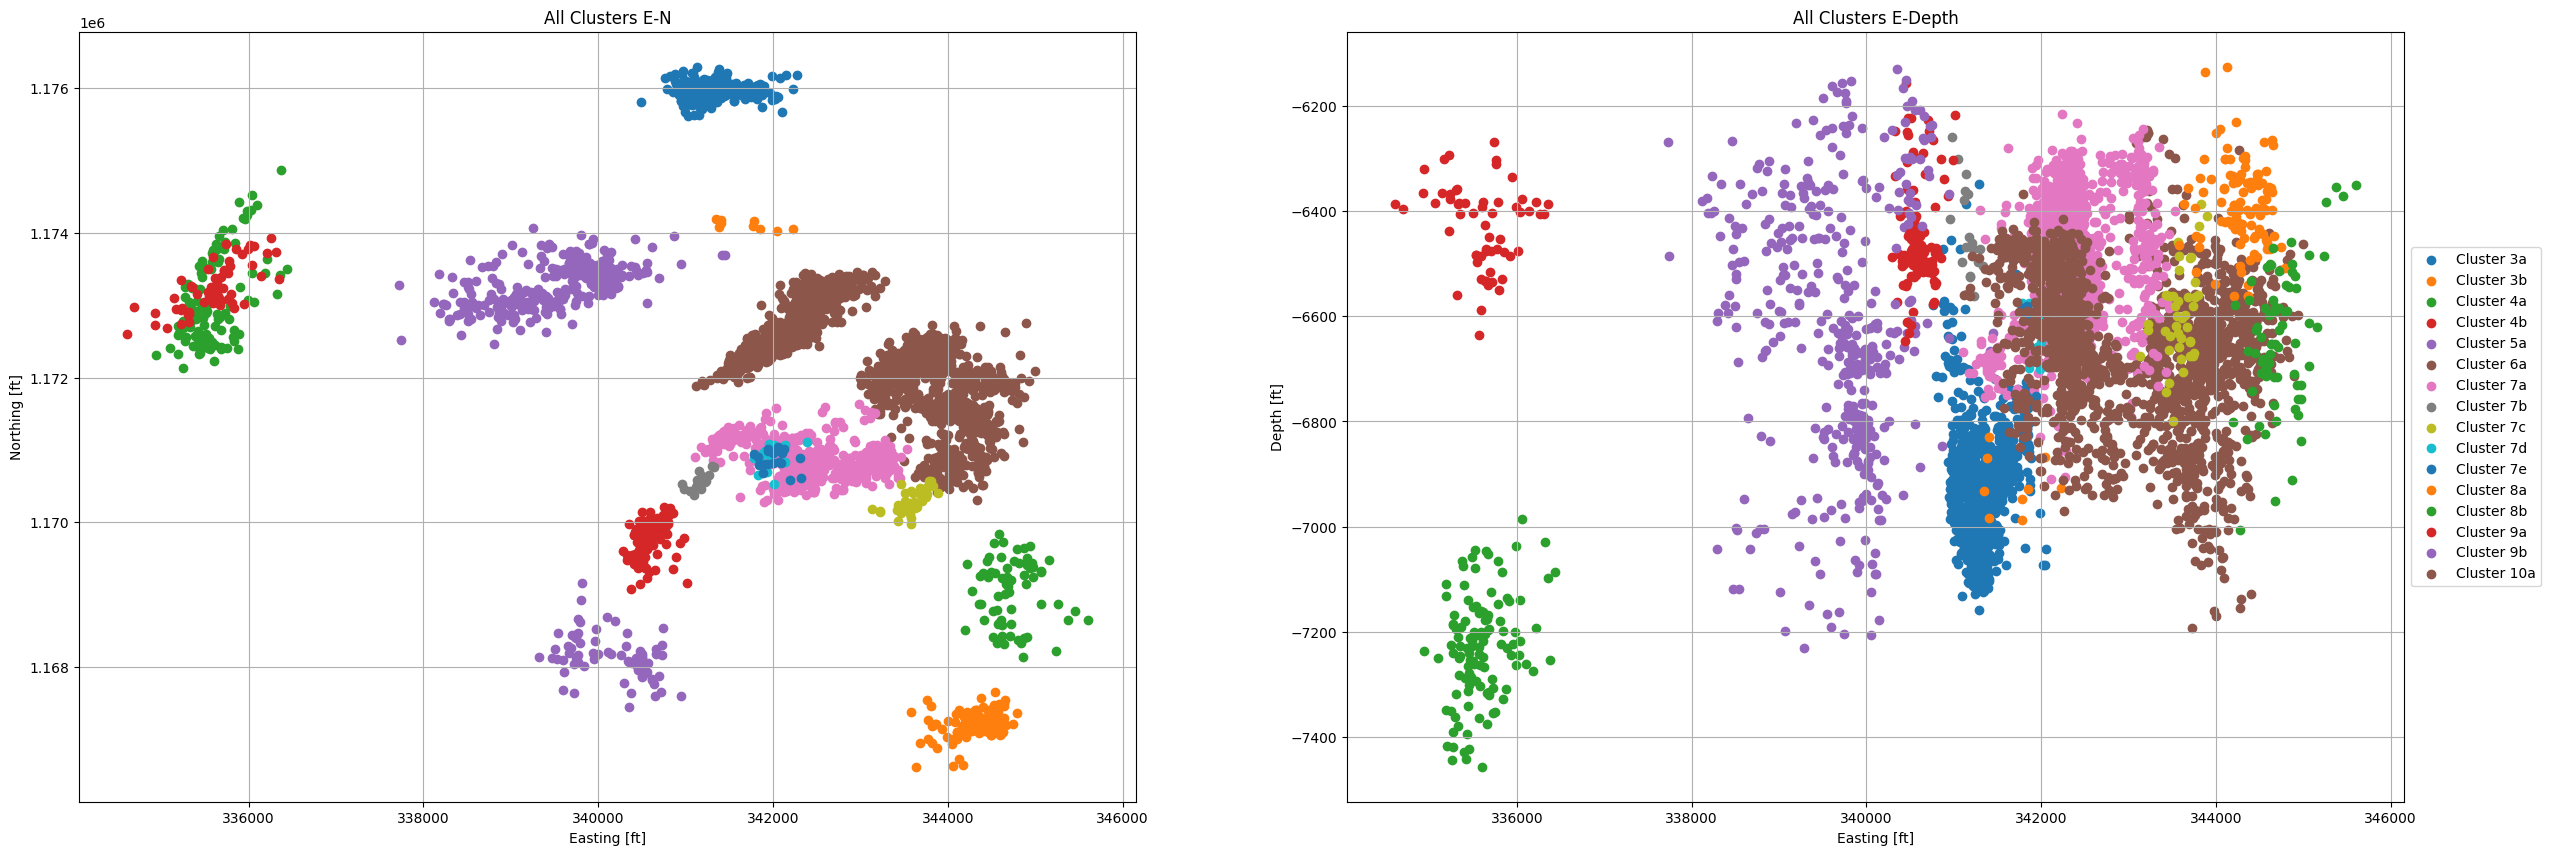

In [66]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(1,2,1)
ax.scatter(cluster_3a[:,1], cluster_3a[:,0], label='Cluster 3a')
ax.scatter(cluster_3b[:,1], cluster_3b[:,0], label='Cluster 3b')
ax.scatter(cluster_4a[:,1], cluster_4a[:,0], label='Cluster 4a')
ax.scatter(cluster_4b[:,1], cluster_4b[:,0], label='Cluster 4b')
ax.scatter(cluster_5a[:,1], cluster_5a[:,0], label='Cluster 5a')
ax.scatter(cluster_6a[:,1], cluster_6a[:,0], label='Cluster 6a')
ax.scatter(cluster_7a[:,1], cluster_7a[:,0], label='Cluster 7a')
ax.scatter(cluster_7b[:,1], cluster_7b[:,0], label='Cluster 7b')
ax.scatter(cluster_7c[:,1], cluster_7c[:,0], label='Cluster 7c')
ax.scatter(cluster_7d[:,1], cluster_7d[:,0], label='Cluster 7d')
ax.scatter(cluster_7e[:,1], cluster_7e[:,0], label='Cluster 7e')
ax.scatter(cluster_8a[:,1], cluster_8a[:,0], label='Cluster 8a')
ax.scatter(cluster_8b[:,1], cluster_8b[:,0], label='Cluster 8b')
ax.scatter(cluster_9a[:,1], cluster_9a[:,0], label='Cluster 9a')
ax.scatter(cluster_9b[:,1], cluster_9b[:,0], label='Cluster 9b')
ax.scatter(cluster_10a[:,1], cluster_10a[:,0], label='Cluster 10a')

ax.set_ylabel("Northing [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()

# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('All Clusters E-N')

ax = fig.add_subplot(1,2,2)
ax.scatter(cluster_3a[:,1], cluster_3a[:,2], label='Cluster 3a')
ax.scatter(cluster_3b[:,1], cluster_3b[:,2], label='Cluster 3b')
ax.scatter(cluster_4a[:,1], cluster_4a[:,2], label='Cluster 4a')
ax.scatter(cluster_4b[:,1], cluster_4b[:,2], label='Cluster 4b')
ax.scatter(cluster_5a[:,1], cluster_5a[:,2], label='Cluster 5a')
ax.scatter(cluster_6a[:,1], cluster_6a[:,2], label='Cluster 6a')
ax.scatter(cluster_7a[:,1], cluster_7a[:,2], label='Cluster 7a')
ax.scatter(cluster_7b[:,1], cluster_7b[:,2], label='Cluster 7b')
ax.scatter(cluster_7c[:,1], cluster_7c[:,2], label='Cluster 7c')
ax.scatter(cluster_7d[:,1], cluster_7d[:,2], label='Cluster 7d')
ax.scatter(cluster_7e[:,1], cluster_7e[:,2], label='Cluster 7e')
ax.scatter(cluster_8a[:,1], cluster_8a[:,2], label='Cluster 8a')
ax.scatter(cluster_8b[:,1], cluster_8b[:,2], label='Cluster 8b')
ax.scatter(cluster_9a[:,1], cluster_9a[:,2], label='Cluster 9a')
ax.scatter(cluster_9b[:,1], cluster_9b[:,2], label='Cluster 9b')
ax.scatter(cluster_10a[:,1], cluster_10a[:,2], label='Cluster 10a')
ax.set_ylabel("Depth [ft]")
ax.set_xlabel("Easting [ft]")
ax.grid()

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('All Clusters E-Depth')

In [ ]:
count_data = {'Cluster Number': "Cluster Count",
                'Cluster 3a': [len(cluster_3a)],
                'Cluster 3b': [len(cluster_3b)],
                'Cluster 4a': [len(cluster_4a)],
                'Cluster 4b': [len(cluster_4b)],
                'Cluster 5a': [len(cluster_5a)],
                'Cluster 6a': [len(cluster_6a)],
                'Cluster 7a': [len(cluster_7a)],
                'Cluster 7b': [len(cluster_7b)],
                'Cluster 7c': [len(cluster_7c)],
                'Cluster 7d': [len(cluster_7d)],
                'Cluster 7e': [len(cluster_7e)],
                'Cluster 8a': [len(cluster_8a)],
                'Cluster 8b': [len(cluster_8b)],
                'Cluster 9a': [len(cluster_9a)],
                'Cluster 9b': [len(cluster_9b)],
                'Cluster 10a': [len(cluster_10a)]
}
count_df = pd.DataFrame(count_data)
display(count_df)

Cluster Number  Cluster 3a  Cluster 3b  Cluster 4a  Cluster 4b  Cluster 5a  \
0  Cluster Count         894           9         115          59         353   

   Cluster 6a  Cluster 7a  Cluster 7b  Cluster 7c  Cluster 7d  Cluster 7e  \
0         899        1385          19          42          24          19   

   Cluster 8a  Cluster 8b  Cluster 9a  Cluster 9b  Cluster 10a  
0         104          71         116          79          852

# Fit Planes through Clusters

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def plane_optimz(points):
  # Fit a plane through the points
  model = LinearRegression()
  model.fit(np.column_stack((points[:,0], points[:,1])), points[:,2])
  coefficients = model.coef_

  # Calculate R^2 score
  Z_pred = model.predict(np.column_stack((points[:,0], points[:,1])))
  r2 = r2_score(points[:,2], Z_pred)
  print("R^2 Score:", r2)

  # Calculate plane parameters
  x_range = np.linspace(min(points[:,0]), max(points[:,0]), 10)
  y_range = np.linspace(min(points[:,1]), max(points[:,1]), 10)
  X_plane, Y_plane = np.meshgrid(x_range, y_range)
  Z_plane = model.predict(np.column_stack((X_plane.ravel(), Y_plane.ravel())))
  Z_plane = Z_plane.reshape(X_plane.shape)

  # Plot points and plane
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot points
  ax.scatter(points[:,0], points[:,1], points[:,2], color='r', label='Data Points')

  # Plot plane
  ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.5, rstride=100, cstride=100, cmap='viridis', label='Fitted Plane')

  # Set labels and title
  ax.set_xlabel('Northing [ft]')
  ax.set_ylabel('Easting [ft]')
  ax.set_zlabel('Depth [ft]')
  ax.set_title('Fitting a Plane through 3D Points (R^2 = {:.2f})'.format(r2))

  # # Set aspect ratio to 'equal'
  # ax.set_box_aspect([1, 1, 1])
  plt.show()

  return X_plane, Y_plane, Z_plane

R^2 Score: 0.38776369208213035


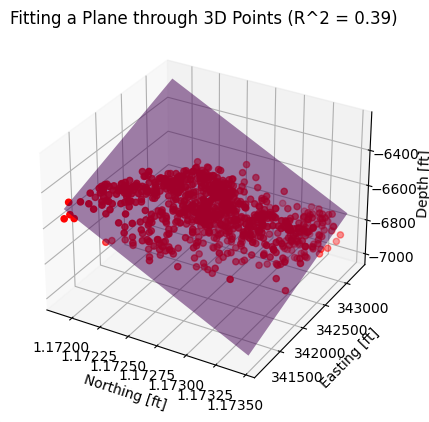

In [ ]:
x_p, y_p, z_p = plane_optimz(cluster_10a[:, 0:-1])

In [ ]:
def fit_plane(data):
  plane = Plane.best_fit(Points(data))
  centroid_pt = np.array([plane.point[0], plane.point[1], plane.point[2]])
  normal_vec = np.array([plane.vector[0], plane.vector[1], plane.vector[2]])

  d = -centroid_pt.dot(normal_vec)

  xx, yy = np.meshgrid(data[:,0], data[:,1])

  z = (-normal_vec[0]*xx - normal_vec[1]*yy - d) * 1./normal_vec[2]

  return xx, yy, z

In [ ]:
xx3a, yy3a, z3a = fit_plane(cluster_3a[:,:-1])
# xx4, yy4, z4 = fit_plane(cluster_4)
# xx5, yy5, z5 = fit_plane(cluster_5)
# xx6, yy6, z6 = fit_plane(cluster_6)
# xx7, yy7, z7 = fit_plane(cluster_7)
# xx8, yy8, z8 = fit_plane(cluster_8)
# xx9, yy9, z9 = fit_plane(cluster_9)
# xx10, yy10, z10 = fit_plane(cluster_10)

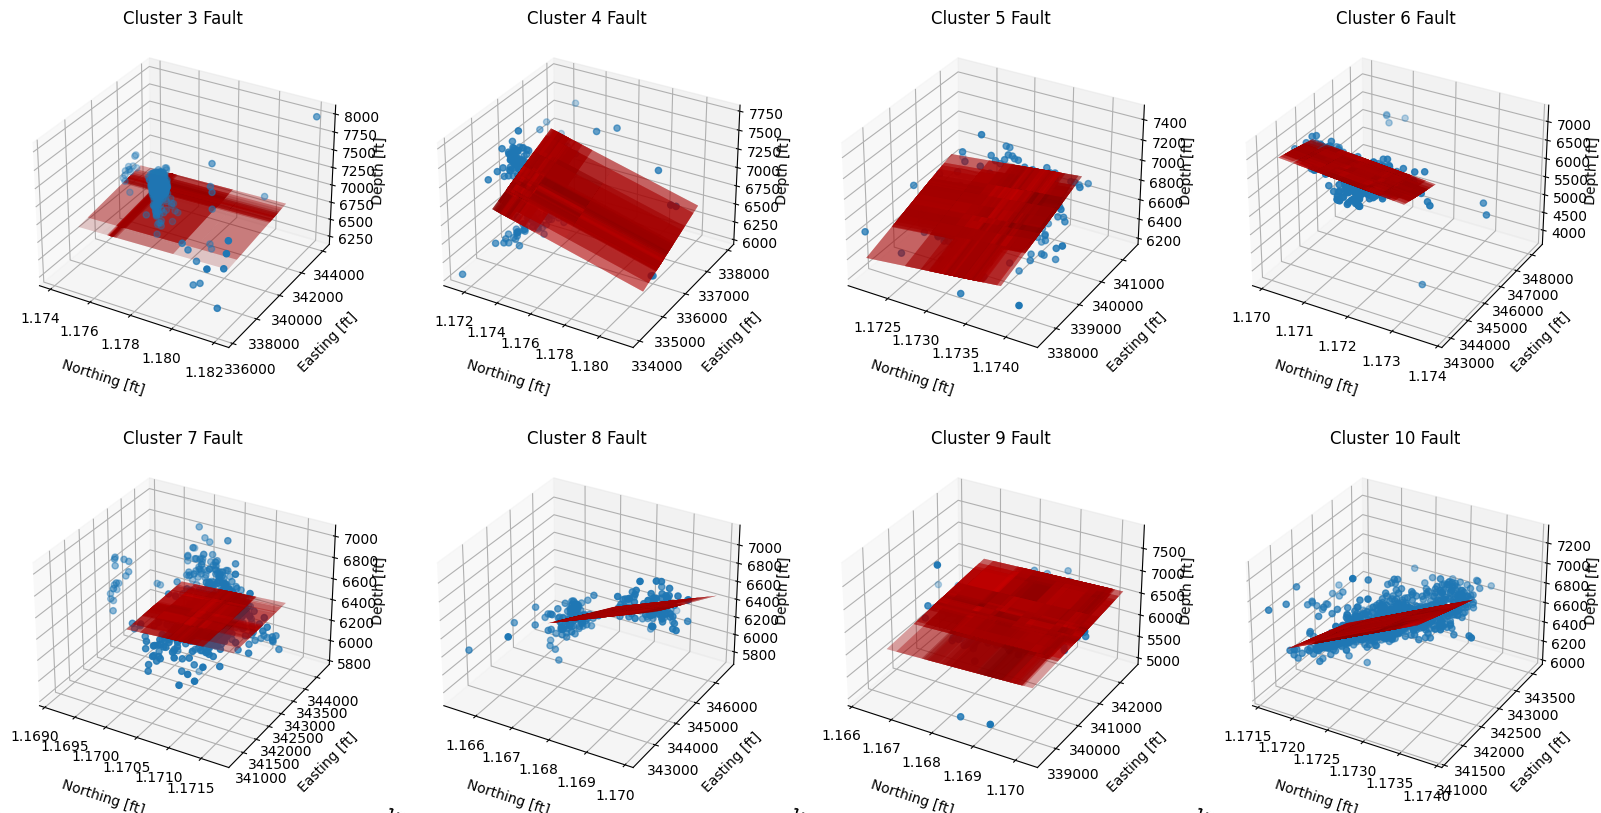

In [ ]:
# set up a figure twice as wide as it is tall
# fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(figsize=(20,10))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(2, 4, 1, projection='3d')

ax.plot_surface(xx3, yy3, z3, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_3[:,0], cluster_3[:,1],cluster_3[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 3 Fault')

# ax.set_zlim(-1.01, 1.01)
# fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 2, projection='3d')

ax.plot_surface(xx4, yy4, z4, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_4[:,0], cluster_4[:,1],cluster_4[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 4 Fault')

# ==============
# Third subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 3, projection='3d')

ax.plot_surface(xx5, yy5, z5, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_5[:,0], cluster_5[:,1],cluster_5[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 5 Fault')

# ==============
# Fourth subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 4, projection='3d')

ax.plot_surface(xx6, yy6, z6, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_6[:,0], cluster_6[:,1],cluster_6[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 6 Fault')

# ==============
# Fifth subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 5, projection='3d')

ax.plot_surface(xx7, yy7, z7, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_7[:,0], cluster_7[:,1],cluster_7[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 7 Fault')

# ==============
# Sixth subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 6, projection='3d')

ax.plot_surface(xx8, yy8, z8, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_8[:,0], cluster_8[:,1],cluster_8[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 8 Fault')

# ==============
# Seventh subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 7, projection='3d')

ax.plot_surface(xx9, yy9, z9, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_9[:,0], cluster_9[:,1],cluster_9[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 9 Fault')

# ==============
# Eighth subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 4, 8, projection='3d')

ax.plot_surface(xx10, yy10, z10, vmin=0, alpha=0.2, color='red')
ax.scatter(cluster_10[:,0], cluster_10[:,1],cluster_10[:,2])
ax.set_xlabel("Northing [ft]")
ax.xaxis.labelpad=10
ax.set_ylabel("Easting [ft]")
ax.yaxis.labelpad=10
ax.set_zlabel("Depth [ft]")
ax.zaxis.labelpad=-0.2
plt.title('Cluster 10 Fault')

plt.show()

In [ ]:
label_dic_1 = {'x': 'Northing [ft]', 'y' : 'Easting [ft]', 'z' : 'Depth [ft]'} ## Check Axis Titles !!!

In [9]:
fig = px.scatter_3d(x=cluster_3a[:,0], y=cluster_3a[:,1], z=cluster_3a[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_3a[:,0], y=cluster_3a[:,1], z=z3a, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 3a Fault Plane")
# fig.show(renderer="colab")
py.iplot(fig, filename='Cluster_3') ## Uncomment to save HTML plot

NameError: name 'px' is not defined

In [ ]:
fig = px.scatter_3d(x=cluster_4[:,0], y=cluster_4[:,1], z=cluster_4[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_4[:,0], y=cluster_4[:,1], z=z4, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 4 Fault Plane")
fig.show(renderer="colab")
# py.iplot(fig, filename='Cluster_4') ## Uncomment to save HTML plot

In [10]:
fig = px.scatter_3d(x=cluster_5[:,0], y=cluster_5[:,1], z=cluster_5[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_5[:,0], y=cluster_5[:,1], z=z5, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 5 Fault Plane")
fig.show(renderer="colab")
py.iplot(fig, filename='Cluster_5') ## Uncomment to save HTML plot

NameError: name 'px' is not defined

In [11]:
fig = px.scatter_3d(x=cluster_6[:,0], y=cluster_6[:,1], z=cluster_6[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_6[:,0], y=cluster_6[:,1], z=z6, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 6 Fault Plane")
fig.show(renderer="colab")
# py.iplot(fig, filename='Cluster_6') ## Uncomment to save HTML plot

NameError: name 'px' is not defined

In [ ]:
fig = px.scatter_3d(x=cluster_7[:,0], y=cluster_7[:,1], z=cluster_7[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_7[:,0], y=cluster_7[:,1], z=z7, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 7 Fault Plane")
fig.show(renderer="colab")
py.iplot(fig, filename='Cluster_7') ## Uncomment to save HTML plot

In [ ]:
fig = px.scatter_3d(x=cluster_8[:,0], y=cluster_8[:,1], z=cluster_8[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_8[:,0], y=cluster_8[:,1], z=z8, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 8 Fault Plane")
fig.show(renderer="colab")
py.iplot(fig, filename='Cluster_8') ## Uncomment to save HTML plot

In [ ]:
fig = px.scatter_3d(x=cluster_9[:,0], y=cluster_9[:,1], z=cluster_9[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_9[:,0], y=cluster_9[:,1], z=z9, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 9 Fault Plane")
fig.show(renderer="colab")
py.iplot(fig, filename='Cluster_9') ## Uncomment to save HTML plot

In [12]:
fig = px.scatter_3d(x=cluster_10[:,0], y=cluster_10[:,1], z=cluster_10[:,2], labels=label_dic_1)
fig.add_surface(x= cluster_10[:,0], y=cluster_10[:,1], z=z10, opacity=0.009, colorbar={"title": "Depth [ft]"})
fig.update_layout(title_text="Cluster 10 Fault Plane")
fig.show(renderer="colab")
py.iplot(fig, filename='Cluster_10') ## Uncomment to save HTML plot

NameError: name 'px' is not defined

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data = [
   go.Surface(x = cluster_3[:,0], y = cluster_3[:,1], z = z3),
   go.Scatter3d(x=cluster_3[:,0], y=cluster_3[:,1], z=cluster_3[:,2], mode='markers', surfacecolor='green'),

   go.Surface(x = cluster_4[:,0], y = cluster_4[:,1], z = z4),
   go.Scatter3d(x=cluster_4[:,0], y=cluster_4[:,1], z=cluster_4[:,2], mode='markers', surfacecolor='red'),

   go.Surface(x = cluster_5[:,0], y = cluster_5[:,1], z = z5),
   go.Scatter3d(x=cluster_5[:,0], y=cluster_5[:,1], z=cluster_5[:,2], mode='markers', surfacecolor='purple'),

   go.Surface(x = cluster_6[:,0], y = cluster_6[:,1], z = z6),
   go.Scatter3d(x=cluster_6[:,0], y=cluster_6[:,1], z=cluster_6[:,2], mode='markers', surfacecolor='blue'),

   go.Surface(x = cluster_7[:,0], y = cluster_7[:,1], z = z7),
   go.Scatter3d(x=cluster_7[:,0], y=cluster_7[:,1], z=cluster_7[:,2], mode='markers', surfacecolor='yellow'),

   go.Surface(x = cluster_8[:,0], y = cluster_8[:,1], z = z8),
   go.Scatter3d(x=cluster_8[:,0], y=cluster_8[:,1], z=cluster_8[:,2], mode='markers', surfacecolor='magenta'),

   go.Surface(x = cluster_9[:,0], y = cluster_9[:,1], z = z9),
   go.Scatter3d(x=cluster_9[:,0], y=cluster_9[:,1], z=cluster_9[:,2], mode='markers', surfacecolor='brown'),

   go.Surface(x = cluster_10[:,0], y = cluster_10[:,1], z = z10),
   go.Scatter3d(x=cluster_10[:,0], y=cluster_10[:,1], z=cluster_10[:,2], mode='markers', surfacecolor='black'),

   ])

fig.update_layout(scene = dict(
                    xaxis_title='Northing [ft]',
                    yaxis_title='Easting [ft]',
                    zaxis_title='Depth [ft]'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), title = 'Fault Planes for 8 Clusters')

fig.show(renderer="colab")
py.iplot(fig, filename='All_Clusters') ## Uncomment to save HTML plot